# OASIS Brain Stylegan

## Import Packages

In [310]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
# tf_device='/gpu:0'import time
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))


import matplotlib.pyplot as plt
import pandas as pd
from random import random, randint
from tensorflow.keras import layers
from tensorflow.keras import backend as k
from IPython.display import clear_output
import time
from tqdm import tqdm
import numpy as np
import glob
import imageio

print("Import Complete")

2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Import Complete


## Set up constant variables

In [295]:
BATCH_SIZE = 32
EPOCHS = 30
IMAGE_SIZE = 64
h, w = IMAGE_SIZE, IMAGE_SIZE

## Load Data

In [296]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+'\\keras_png_slices_data\\keras_png_slices_train',
    label_mode=None,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(h, w),
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+'\\keras_png_slices_data\\keras_png_slices_test',
    label_mode=None,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(h, w),
    shuffle=True
)

validate_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+'\\keras_png_slices_data\\keras_png_slices_validate',
    label_mode=None,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(h, w),
    shuffle=True
)

Found 9664 files belonging to 1 classes.
Found 544 files belonging to 1 classes.
Found 1120 files belonging to 1 classes.


## Preprocess Images
### Normalization

In [297]:
def preprocess_image(image):
    image = tf.cast(image/255., tf.float32)
    return image

train_ds = train_ds.map(preprocess_image).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()
test_ds = test_ds.map(preprocess_image).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()
validate_ds = validate_ds.map(preprocess_image).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()


## Preview Data

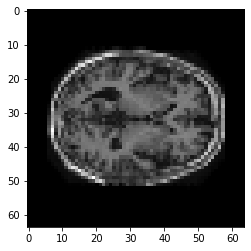

Shape: (64, 64, 1)
Data Type: <dtype: 'float32'>
Min tf.Tensor(0.0, shape=(), dtype=float32)
Max tf.Tensor(0.84411764, shape=(), dtype=float32)


In [298]:
previewImage = list(train_ds.take(1))[0][0]
plt.imshow(previewImage, cmap='gray')
plt.show()

print("Shape:", previewImage.shape)
print("Data Type:", previewImage.dtype)
print("Min", tf.math.reduce_min(previewImage))
print("Max", tf.math.reduce_max(previewImage))

## Initialize Models

In [299]:
LATENT_SIZE = 512

def make_generator_model():

    # AdaIN
    def AdaIN(x, ys, yb):
        x_mean, x_std = k.mean(x), k.std(x)
        ys = tf.reshape(ys, (-1, 1, 1, tf.shape(ys)[-1]))
        yb = tf.reshape(yb, (-1, 1, 1, tf.shape(yb)[-1]))
        return tf.add(tf.multiply(ys, tf.divide(x - x_mean, x_std+1e-7)), yb)

    latent_input0 = layers.Input(shape=(LATENT_SIZE,))
    latent_input1 = layers.Input(shape=(LATENT_SIZE,))
    latent_input2 = layers.Input(shape=(LATENT_SIZE,))
    latent_input3 = layers.Input(shape=(LATENT_SIZE,))
    latent_input4 = layers.Input(shape=(LATENT_SIZE,))

    # Mapping Network
    mnfc_input = layers.Input(shape=(LATENT_SIZE,))
    mnfc = layers.Dense(LATENT_SIZE, activation="relu")(mnfc_input)
    for i in range(3):
        mnfc = layers.Dense(64, activation="relu")(mnfc)
    mnfc = layers.Dense(512, activation="relu")(mnfc)
    mapping_network = tf.keras.Model(inputs=[mnfc_input], outputs=[mnfc])

    w0 = mapping_network(latent_input0)
    w1 = mapping_network(latent_input1)
    w2 = mapping_network(latent_input2)
    w3 = mapping_network(latent_input3)
    w4 = mapping_network(latent_input4)

    # Noises
    noise_input0 = layers.Input(shape=(4, 4, 1))
    n0 = layers.Dense(32, activation="relu")(noise_input0)
    noise_input1 = layers.Input(shape=(8, 8, 1))
    n1 = layers.Dense(32, activation="relu")(noise_input1)
    noise_input2 = layers.Input(shape=(16, 16, 1))
    n2 = layers.Dense(32, activation="relu")(noise_input2)
    noise_input3 = layers.Input(shape=(32, 32, 1))
    n3 = layers.Dense(32, activation="relu")(noise_input3)
    noise_input4 = layers.Input(shape=(64, 64, 1))
    n4 = layers.Dense(32, activation="relu")(noise_input4)

    # synthesis Network
    # 4x4
    l1_1 = layers.Dense(4*4*32, activation="relu")(latent_input0)
    l1_2 = layers.Reshape((4, 4, 32))(l1_1)
    b = layers.Dense(32)(n0)
    l1_3 = layers.Add()([l1_2, b])
    scale_dense = layers.Dense(32)(w0)
    bias_dense = layers.Dense(32)(w0)
    l1_4 = AdaIN(l1_3, scale_dense, bias_dense)
    l1_5 = layers.Conv2D(32, (3, 3), padding="same")(l1_4)
    b = layers.Dense(32)(n0)
    l1_6 = layers.Add()([l1_5, b])
    scale_dense = layers.Dense(32)(w0)
    bias_dense = layers.Dense(32)(w0)
    l1_7 = AdaIN(l1_6, scale_dense, bias_dense)

    # 8x8
    l2_1 = layers.UpSampling2D()(l1_7)
    l2_2 = layers.Conv2D(32, (3, 3), padding="same")(l2_1)
    b = layers.Dense(32)(n1)
    l2_3 = layers.Add()([l2_2, b])
    scale_dense = layers.Dense(32)(w1)
    bias_dense = layers.Dense(32)(w1)
    l2_4 = AdaIN(l2_3, scale_dense, bias_dense)
    l2_5 = layers.Conv2D(32, (3, 3), padding="same")(l2_4)
    b = layers.Dense(32)(n1)
    l2_6 = layers.Add()([l2_5, b])
    scale_dense = layers.Dense(32)(w1)
    bias_dense = layers.Dense(32)(w1)
    l2_7 = AdaIN(l2_6, scale_dense, bias_dense)

    # 16x16
    l3_1 = layers.UpSampling2D()(l2_7)
    l3_2 = layers.Conv2D(32, (3, 3), padding="same")(l3_1)
    b = layers.Dense(32)(n2)
    l3_3 = layers.Add()([l3_2, b])
    scale_dense = layers.Dense(32)(w2)
    bias_dense = layers.Dense(32)(w2)
    l3_4 = AdaIN(l3_3, scale_dense, bias_dense)
    l3_5 = layers.Conv2D(32, (3, 3), padding="same")(l3_4)
    b = layers.Dense(32)(n2)
    l3_6 = layers.Add()([l3_5, b])
    scale_dense = layers.Dense(32)(w2)
    bias_dense = layers.Dense(32)(w2)
    l3_7 = AdaIN(l3_6, scale_dense, bias_dense)

    # 32x32
    l4_1 = layers.UpSampling2D()(l3_7)
    l4_2 = layers.Conv2D(32, (3, 3), padding="same")(l4_1)
    b = layers.Dense(32)(n3)
    l4_3 = layers.Add()([l4_2, b])
    scale_dense = layers.Dense(32)(w3)
    bias_dense = layers.Dense(32)(w3)
    l4_4 = AdaIN(l4_3, scale_dense, bias_dense)
    l4_5 = layers.Conv2D(32, (3, 3), padding="same")(l4_4)
    b = layers.Dense(32)(n3)
    l4_6 = layers.Add()([l4_5, b])
    scale_dense = layers.Dense(32)(w3)
    bias_dense = layers.Dense(32)(w3)
    l4_7 = AdaIN(l4_6, scale_dense, bias_dense)

    # 64x64
    l5_1 = layers.UpSampling2D()(l4_7)
    l5_2 = layers.Conv2D(32, (3, 3), padding="same")(l5_1)
    b = layers.Dense(32)(n4)
    l5_3 = layers.Add()([l5_2, b])
    scale_dense = layers.Dense(32)(w4)
    bias_dense = layers.Dense(32)(w4)
    l5_4 = AdaIN(l5_3, scale_dense, bias_dense)
    l5_5 = layers.Conv2D(32, (3, 3), padding="same")(l5_4)
    b = layers.Dense(32)(n4)
    l5_6 = layers.Add()([l5_5, b])
    scale_dense = layers.Dense(32)(w4)
    bias_dense = layers.Dense(32)(w4)
    l5_7 = AdaIN(l5_6, scale_dense, bias_dense)

    l6 = layers.Dense(1)(l5_7)
    output_layer = layers.Activation(activation="sigmoid")(l6)
    model = tf.keras.Model(inputs=[latent_input0, latent_input1, latent_input2, latent_input3, latent_input4,
                                   noise_input0, noise_input1, noise_input2, noise_input3, noise_input4],
                           outputs=[output_layer])
    return model

model = make_generator_model()
model.summary()

Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_392 (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_398 (InputLayer)          [(None, 4, 4, 1)]    0                                            
__________________________________________________________________________________________________
input_396 (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_395 (InputLayer)          [(None, 512)]        0                                            
___________________________________________________________________________________________

In [300]:
def make_discriminator_model():
    model = tf.keras.models.Sequential()

    filter_size = 24

    model.add(layers.Conv2D(filter_size, (3, 3), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(filter_size, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filter_size, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(filter_size, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

In [301]:
generator = make_generator_model()
discriminator = make_discriminator_model()

## Define Losses

In [302]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    realLoss = cross_entropy(tf.ones_like(real_output), real_output)
    fakeLoss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return realLoss + fakeLoss

def generator_loss(fakeOutput):
    return cross_entropy(tf.ones_like(fakeOutput), fakeOutput)

## Define Optimizers

In [303]:
generatorOptimizer = tf.keras.optimizers.Adam(1e-5, beta_1=.5)
discriminatorOptimizer = tf.keras.optimizers.Adam(1e-5, beta_1=.5)

In [304]:
NUM_SAMPLES_TO_GENERATE = 8
NUM_CHECKPOINT = 10


# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = [tf.random.uniform([NUM_SAMPLES_TO_GENERATE, LATENT_SIZE]) for i in range(5)] + [tf.random.uniform([NUM_SAMPLES_TO_GENERATE, 4 * 2**i, 4 * 2**i, 1]) for i in range(5)]

In [305]:
checkpoint_dir = "./checkpoints"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generatorOptimizer,
    discriminator_optimizer=discriminatorOptimizer,
    generator=generator,
    discriminator=discriminator,
)

## Define Training Steps

In [306]:
@tf.function
def train_step(images):
    latents = [tf.random.uniform([BATCH_SIZE, LATENT_SIZE]) for i in range(5)]
    noises = [tf.random.uniform([BATCH_SIZE, 4 * 2**i, 4 * 2**i, 1]) for i in range(5)]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(tuple(latents+noises), training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        genLoss = generator_loss(fake_output)
        discLoss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(genLoss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(discLoss, discriminator.trainable_variables)

        generatorOptimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminatorOptimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return genLoss, discLoss


In [307]:
def generate_and_save_images(model, epoch, test_input, history):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 4), constrained_layout=True)

    for i in range(predictions.shape[0]):
        plt.subplot(2, 4, i + 1)
        plt.imshow((predictions[i].numpy()), cmap="gray")
        plt.axis("off")

    plt.savefig("./img/image_at_epoch_{:04d}.png".format(epoch))
    plt.show()
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.legend(["Generator Loss", "Discriminator Loss"])
    plt.show()

In [308]:
def train(dataset, epochs):
    history = {
        'gen_loss': [],
        'disc_loss': []
    }

    generate_and_save_images(generator, 0, seed, history)

    for epoch in range(epochs):
        start = time.time()

        gen_loss = []
        disc_loss = []
        for image_batch in tqdm(dataset):
            h = train_step(image_batch)
            gen_loss.append(h[0])
            disc_loss.append(h[1])
        history['gen_loss'].append(tf.math.reduce_mean(gen_loss))
        history['disc_loss'].append(tf.math.reduce_mean(disc_loss))
        print(f"EPOCH: {epoch}\ngen_loss: {history['gen_loss'][-1]}\ndisc_loss: {history['disc_loss'][-1]}")

        # Produce images for the GIF as you go
        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed, history)

        # Save the model every 15 epochs
        if (epoch + 1) % NUM_CHECKPOINT == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("Time for epoch {} is {} sec".format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed, history)
    return history


## Train Model

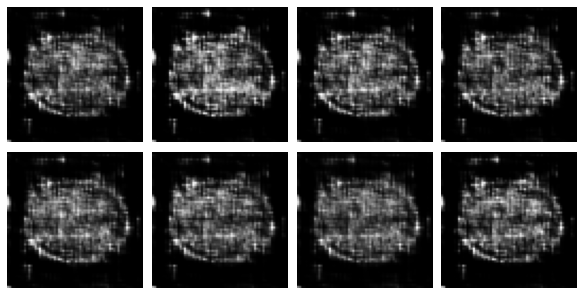

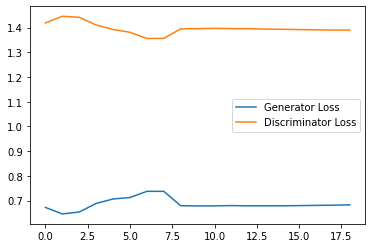

  1%|          | 3/302 [00:00<00:13, 22.14it/s]

Time for epoch 19 is 19.974000930786133 sec


 29%|██▉       | 88/302 [00:05<00:12, 16.79it/s]


KeyboardInterrupt: 

In [309]:
print("Starting")
history = train(train_ds, EPOCHS)
print("Finished")


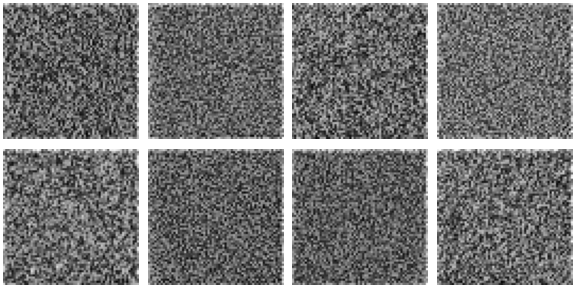

In [313]:
anim_file = "stylegan_BRAIN.gif"

filenames = glob.glob("./img/image_at_epoch_*.png")
images = [imageio.imread(filename) for filename in sorted(filenames)]
imageio.mimsave(anim_file, images, fps=8)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Evaluate model